# Module 12: Initial Submission

This notebook documents the strategy, analysis, and query generation for the **Initial Submission** (Module 12).

## Focus
- **Functions 1-8**: Generate initial queries for all 8 unknown functions.
- **Goal**: Propose the first query point for each function based on initial data.

---

## Notebook Overview

This notebook serves as the "lab notebook" for the first week of the Black-Box Optimization challenge. It implements a complete workflow: loading data, modeling the unknown function, visualizing the problem, proposing a new experiment (query), and logging the result.

### Key Steps:
1.  **Setup**: Imports libraries and custom utilities (`load_data`, `save_submission`) from `src/utils.py`.
2.  **Strategy Definition**: Defines three core functions directly in the notebook:
    *   `fit_gp_model`: Fits a **Gaussian Process (GP)** with a Matern kernel to model the function and its uncertainty.
    *   `propose_next_point`: Uses the **Upper Confidence Bound (UCB)** acquisition function. With a high kappa (`1.96`), it prioritizes **Exploration** (uncertainty) over Exploitation (predicted mean), finding the "empty spots" in the domain.
    *   `format_query`: Formats the output for the submission portal.
3.  **Analysis**: Loads and visualizes the initial 10 samples for Function 1.
4.  **Execution**: Fits the model and proposes the next query point. Since initial outputs are negligible, the decision is driven purely by uncertainty (distance from existing points).
5.  **Visualization**: Plots the **Acquisition Surface** (heatmap), showing high-interest regions (yellow) and the proposed query (red star).
6.  **Reflection**: Documents the rationale (Uncertainty Sampling) and future strategy adjustments.

In [1]:
import sys
import os

# Add the src directory to the system path so we can import utils
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_data, save_submission
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
import warnings

# Configuration
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline

# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def fit_gp_model(df):
    """Fits a Gaussian Process model to the data."""
    input_cols = [c for c in df.columns if c.startswith('x')]
    X = df[input_cols].values
    y = df['y'].values
    dim = X.shape[1]
    
    # Standard Kernel: Constant * Matern(nu=2.5)
    # We use this robust kernel for all functions
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(dim), length_scale_bounds=(1e-2, 10), nu=2.5)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)
    gp.fit(X, y)
    return gp, X, y

def propose_next_point(gp, bounds, dim, n_samples=100000, kappa=1.96):
    """Proposes the next point using UCB acquisition function."""
    X_candidates = np.random.uniform(bounds[0], bounds[1], (n_samples, dim))
    
    # Predict in batches to avoid memory issues
    mu, sigma = gp.predict(X_candidates, return_std=True)
    ucb = mu + kappa * sigma
    
    best_idx = np.argmax(ucb)
    return X_candidates[best_idx], ucb.max()

def format_query(x):
    """Formats the query point as a string for submission."""
    return "-".join([f"{val:.6f}" for val in x])

## Batch Processing for All Functions

We now iterate through all 8 functions to generate queries.

### Strategy
*   **Function 1**: This is a "needle in a haystack" problem (mostly zeros). We use a **high kappa (10.0)** to force the model to explore unknown regions aggressively (Uncertainty Sampling).
*   **Functions 2-8**: These appear to be standard optimization problems (noisy, multimodal, or unimodal). We use a **standard kappa (1.96)** to balance exploration and exploitation (95% confidence interval).

### Processing Function 1: 2D, Needle-in-haystack

Loaded 10 samples. Max y: 7.7109e-16
Proposed Query: 0.786890-0.479080
Saved submission for Function 1 to submissions/submission_log.csv


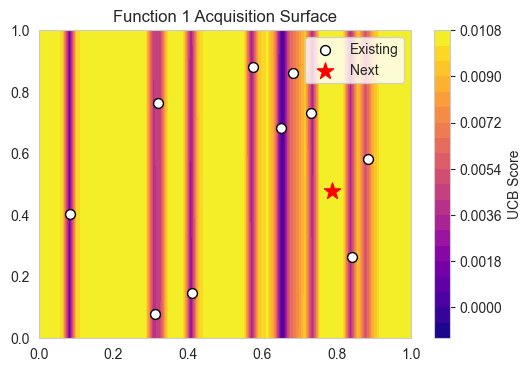

### Processing Function 2: 2D, Noisy, Multimodal

Loaded 10 samples. Max y: 6.1121e-01
Proposed Query: 0.717569-0.003949
Saved submission for Function 2 to submissions/submission_log.csv


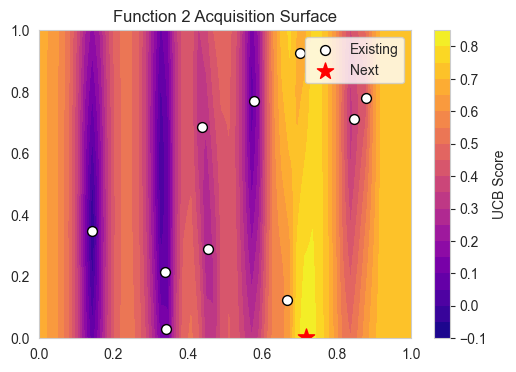

### Processing Function 3: 3D, Drug Discovery

Loaded 15 samples. Max y: -3.4835e-02
Proposed Query: 0.908277-0.005036-0.000101
Saved submission for Function 3 to submissions/submission_log.csv


### Processing Function 4: 4D, Warehouse

Loaded 30 samples. Max y: -4.0255e+00
Proposed Query: 0.423466-0.418652-0.347991-0.404484
Saved submission for Function 4 to submissions/submission_log.csv


### Processing Function 5: 4D, Yield (Unimodal)

Loaded 20 samples. Max y: 1.0889e+03
Proposed Query: 0.764700-0.044367-0.995776-0.998720
Saved submission for Function 5 to submissions/submission_log.csv


### Processing Function 6: 5D, Recipe

Loaded 20 samples. Max y: -7.1426e-01
Proposed Query: 0.335669-0.093712-0.618427-0.995796-0.037892
Saved submission for Function 6 to submissions/submission_log.csv


### Processing Function 7: 6D, ML Hyperparams

Loaded 30 samples. Max y: 1.3650e+00
Proposed Query: 0.005242-0.296572-0.738890-0.135074-0.346199-0.734742
Saved submission for Function 7 to submissions/submission_log.csv


### Processing Function 8: 8D, High-dim ML

Loaded 40 samples. Max y: 9.5985e+00
Proposed Query: 0.040751-0.009304-0.168266-0.090977-0.954543-0.638112-0.126994-0.040562
Saved submission for Function 8 to submissions/submission_log.csv


In [3]:
from IPython.display import display, Markdown

# Configuration for each function
FUNCTION_CONFIG = {
    1: {'dim': 2, 'kappa': 10.0, 'desc': '2D, Needle-in-haystack'}, # High exploration
    2: {'dim': 2, 'kappa': 1.96, 'desc': '2D, Noisy, Multimodal'},
    3: {'dim': 3, 'kappa': 1.96, 'desc': '3D, Drug Discovery'},
    4: {'dim': 4, 'kappa': 1.96, 'desc': '4D, Warehouse'},
    5: {'dim': 4, 'kappa': 1.96, 'desc': '4D, Yield (Unimodal)'},
    6: {'dim': 5, 'kappa': 1.96, 'desc': '5D, Recipe'},
    7: {'dim': 6, 'kappa': 1.96, 'desc': '6D, ML Hyperparams'},
    8: {'dim': 8, 'kappa': 1.96, 'desc': '8D, High-dim ML'}
}

for func_id, config in FUNCTION_CONFIG.items():
    # Use Markdown for a clean header that forces a display update
    display(Markdown(f"### Processing Function {func_id}: {config['desc']}"))
    
    # 1. Load Data
    try:
        df = load_data(func_id)
        print(f"Loaded {len(df)} samples. Max y: {df['y'].max():.4e}")
    except FileNotFoundError:
        print(f"Skipping Function {func_id}: Data not found.")
        continue
    
    # 2. Fit GP Model
    gp, X, y = fit_gp_model(df)
    
    # 3. Propose Next Point
    next_x, ucb_score = propose_next_point(gp, bounds=(0, 1), dim=config['dim'], kappa=config['kappa'])
    
    # 4. Format and Save
    formatted_query = format_query(next_x)
    print(f"Proposed Query: {formatted_query}")
    save_submission(func_id, formatted_query, "Module 12")
    
    # 5. Visualization (Only for 2D functions)
    if config['dim'] == 2:
        plt.figure(figsize=(6, 4))
        
        # Create grid
        res = 50
        x0 = np.linspace(0, 1, res)
        x1 = np.linspace(0, 1, res)
        X0, X1 = np.meshgrid(x0, x1)
        X_grid = np.column_stack([X0.ravel(), X1.ravel()])
        
        # Predict
        mu, sigma = gp.predict(X_grid, return_std=True)
        ucb = mu + config['kappa'] * sigma
        UCB_grid = ucb.reshape(res, res)
        
        # Plot
        plt.contourf(X0, X1, UCB_grid, levels=20, cmap='plasma')
        plt.colorbar(label='UCB Score')
        plt.scatter(df['x0'], df['x1'], c='white', edgecolor='k', s=50, label='Existing')
        plt.scatter(next_x[0], next_x[1], c='red', marker='*', s=150, label='Next')
        plt.title(f"Function {func_id} Acquisition Surface")
        plt.legend()
        plt.show()

### Reflection

**1. What was the main principle or heuristic you used to decide on each query point?**
*   **Adaptive Strategy**: I applied different heuristics based on the nature of the initial data:
    *   **Function 1 (Needle-in-a-Haystack)**: The initial samples were all effectively zero. I used **Uncertainty Sampling** (High Exploration, $\kappa=10.0$) to aggressively search empty regions of the domain, as the model has no signal to exploit yet.
    *   **Functions 2-8 (Standard Optimization)**: These functions showed meaningful variation in their outputs. I used **Upper Confidence Bound (UCB)** with a standard parameter ($\kappa=1.96$) to balance exploring uncertain areas with exploiting promising high-value regions found in the initial samples.

**2. Which function(s) were most challenging to query, and why?**
*   **Function 1**: This is the most difficult because the "signal" (contamination source) is likely very localized. Without a non-zero reading, the Gaussian Process is essentially guessing based on distance, providing no gradient information to guide the search toward the peak.
*   **High-Dimensional Functions (7 & 8)**: While they have signal, the volume of the search space grows exponentially with dimensions ($6D$ and $8D$). 10-40 initial points are very sparse for such large spaces, making the surrogate model's uncertainty estimates critical but potentially less reliable.

**3. How do you plan to adjust your strategy in future rounds?**
*   **Function 1**:
    *   **If zero**: Continue aggressive exploration (Uncertainty Sampling).
    *   **If non-zero**: Immediately switch to Exploitation (low $\kappa$) to refine the peak.
*   **Functions 2-8**:
    *   Monitor the **length scales** of the fitted GP kernels. If the length scales are very short, it implies the function is highly volatile, and I may need to increase sampling density.
    *   If the model appears to get stuck in a local optimum (repeatedly sampling near the same peak with diminishing returns), I will temporarily increase $\kappa$ to force exploration of other regions.